# 3.5图像分类数据集

In [3]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress',
                   'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


In [4]:
get_fashion_mnist_labels([1,2,4,2])

['trouser', 'pullover', 'coat', 'pullover']

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import sys

sys.path.append("..")
mnist_train = torchvision.datasets.FashionMNIST(root='D:/Datasets',
                                                train=True, download=True,
                                                transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='D:/Datasets',
                                                train=False, download=True,
                                                transform=transforms.ToTensor())

print(type(mnist_train))
print(len(mnist_train))


<class 'torchvision.datasets.mnist.FashionMNIST'>
60000


In [6]:
%matplotlib inline
from IPython import display
def show_fashion_mnist(images, labels):
    display.set_matplotlib_formats('svg') 
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

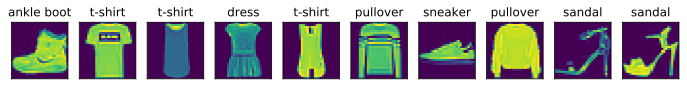

In [7]:
X, y = [], []
for i in range(10):
  X.append(mnist_train[i][0])
  y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

In [8]:
mnist_train[1][0].shape

torch.Size([1, 28, 28])

In [9]:
batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0 # 0表示不⽤额外的进程来加速读取数据
else:
    num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train,
batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test,
batch_size=batch_size, shuffle=False, num_workers=num_workers)
print(num_workers)

0


In [10]:
start = time.time()
for X, y in train_iter:
 continue
print('%.2f sec' % (time.time() - start))

3.97 sec


# 3.6 softmax回归的从零实现

# 3.6.1 获取和读取数据

In [13]:
batch_size = 256
mnist_train = torchvision.datasets.FashionMNIST(root='D:/Datasets', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='D:/Datasets', train=False, download=True, transform=torchvision.transforms.ToTensor())
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=4)


# 3.6.2 初始化模型参数


In [28]:
import numpy as np

num_inputs = 784
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.tensor(np.random.normal(0, 0.01, (1,num_outputs)), dtype=torch.float)
c = torch.zeros(num_outputs, dtype=torch.float)

In [29]:
W

tensor([[ 0.0081, -0.0015,  0.0040,  ..., -0.0015, -0.0161,  0.0080],
        [-0.0040, -0.0081,  0.0196,  ...,  0.0032, -0.0088,  0.0023],
        [-0.0064,  0.0110, -0.0068,  ...,  0.0003,  0.0114,  0.0007],
        ...,
        [-0.0176,  0.0078,  0.0033,  ..., -0.0093,  0.0003,  0.0022],
        [ 0.0011, -0.0036, -0.0145,  ...,  0.0032, -0.0010, -0.0027],
        [-0.0019, -0.0031, -0.0049,  ...,  0.0037,  0.0131,  0.0069]])

In [30]:
b

tensor([[-0.0220, -0.0011, -0.0158, -0.0185, -0.0066,  0.0028, -0.0304, -0.0015,
         -0.0028,  0.0084]])

In [31]:
c

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [32]:
W.requires_grad_(requires_grad=True)

tensor([[ 0.0081, -0.0015,  0.0040,  ..., -0.0015, -0.0161,  0.0080],
        [-0.0040, -0.0081,  0.0196,  ...,  0.0032, -0.0088,  0.0023],
        [-0.0064,  0.0110, -0.0068,  ...,  0.0003,  0.0114,  0.0007],
        ...,
        [-0.0176,  0.0078,  0.0033,  ..., -0.0093,  0.0003,  0.0022],
        [ 0.0011, -0.0036, -0.0145,  ...,  0.0032, -0.0010, -0.0027],
        [-0.0019, -0.0031, -0.0049,  ...,  0.0037,  0.0131,  0.0069]],
       requires_grad=True)

In [33]:
b.requires_grad_(requires_grad=True)

tensor([[-0.0220, -0.0011, -0.0158, -0.0185, -0.0066,  0.0028, -0.0304, -0.0015,
         -0.0028,  0.0084]], requires_grad=True)

# 3.6.3 实现SOFTMAX运算

In [46]:
X = torch.tensor([[1, 2, 3], 
                 [4, 5, 6]],dtype=torch.float)

In [47]:
X.sum(dim=0, keepdim=True).dtype

torch.float32

In [48]:
X.sum(dim=1, keepdim=True)

tensor([[ 6.],
        [15.]])

In [49]:
X/X.sum(dim=0, keepdim=True)

tensor([[0.2000, 0.2857, 0.3333],
        [0.8000, 0.7143, 0.6667]])

In [50]:
def softmax(x):
    x_exp = x.exp()
    partition = x_exp.sum(dim=1,keepdim=True)
    return x_exp/partition

In [51]:
X = torch.rand((2, 5))
X_prob = softmax(X)
print(X_prob, X_prob.sum(dim=1))

tensor([[0.1559, 0.2796, 0.1723, 0.1809, 0.2112],
        [0.2801, 0.1155, 0.1281, 0.1823, 0.2940]]) tensor([1.0000, 1.0000])


# 3.6.4 定义模型

In [52]:
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

# 3.6.5 定义损失函数

In [81]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.LongTensor([0, 2])
y_hat.gather(1, y.view(-1, 1))

tensor([[0.1000],
        [0.5000]])

In [82]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

In [83]:
cross_entropy(y_hat, y)

tensor([[2.3026],
        [0.6931]])

In [84]:
torch.log(y_hat)
y_hat.dtype

torch.float32

# 3.6.6 计算分类准确率

In [55]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [57]:
print(accuracy(y_hat, y))

0.5


In [87]:
(y_hat.argmax(dim=1) == y)

tensor([0, 1], dtype=torch.uint8)

In [58]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [59]:
print(evaluate_accuracy(test_iter, net))

0.1323


# 3.6.7 训练模型

In [64]:
num_epochs, lr = 5, 0.1
# 本函数已保存在d2lzh包中⽅便以后使⽤
def train_ch3(net, train_iter, test_iter, loss, num_epochs,
batch_size, params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
 
            l.backward()
            if optimizer is None:
                for param in params:
                    param.data -= lr * param.grad / batch_size
            else:
                optimizer.step() # “softmax回归的简洁实现”⼀节将⽤到
 
 
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f' 
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, 
                 test_acc))

In [65]:
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.7841, train acc 0.750, test acc 0.784
epoch 2, loss 0.5718, train acc 0.811, test acc 0.804
epoch 3, loss 0.5254, train acc 0.825, test acc 0.820
epoch 4, loss 0.5021, train acc 0.832, test acc 0.825
epoch 5, loss 0.4857, train acc 0.836, test acc 0.830


# 3.6.8 预测

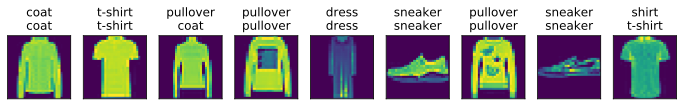

In [68]:
X, y = iter(test_iter).next()
true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels,
pred_labels)]
show_fashion_mnist(X[0:9], titles[0:9])

# 3.7 SOFTMAX回归的简洁实现

In [125]:
import torch
from torch.nn import init
from torch import nn
import numpy as np
import sys


# 3.7.1 获取和读取数据

In [126]:
batch_size = 256
mnist_train = torchvision.datasets.FashionMNIST(root='D:/Datasets', train=True, 
                                                download=True, 
                                                transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='D:/Datasets', train=False, 
                                                download=True, 
                                                transform=torchvision.transforms.ToTensor())
train_iter = torch.utils.data.DataLoader(mnist_train, shuffle=True, batch_size=batch_size, num_workers=4)
test_iter = torch.utils.data.DataLoader(mnist_test, shuffle=True, batch_size=batch_size, num_workers=4)

# 3.7.2 定义和初始化模型

In [127]:
from torch import nn

num_inputs = 784
num_outputs = 10

class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
    def forward(self, x):
        y = self.linear(x.view(x.shape[0],-1))
        return y

net = LinearNet(num_inputs, num_outputs)

In [128]:
class FlattenLayer(nn.Module):
     def __init__(self):
         super(FlattenLayer, self).__init__()
     def forward(self, x): # x shape: (batch, *, *, ...)
         return x.view(x.shape[0], -1)

In [129]:
from collections import OrderedDict
net = nn.Sequential(
    # FlattenLayer(),
    # nn.Linear(num_inputs, num_outputs)
    OrderedDict([
        ('flatten', FlattenLayer()), 
        ('linear', nn.Linear(num_inputs, num_outputs))])
    )

In [130]:
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

# 3.7.3 SOFTMAX和交叉熵损失函数

In [131]:
loss = torch.nn.CrossEntropyLoss()


# 3.7.4 定义优化算法

In [132]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

# 3.7.5 训练模型

In [134]:
num_epochs = 5
train_ch3(net, train_iter, test_iter, loss, num_epochs,
batch_size, None, None, optimizer)

epoch 1, loss 0.0031, train acc 0.749, test acc 0.788
epoch 2, loss 0.0022, train acc 0.814, test acc 0.795
epoch 3, loss 0.0021, train acc 0.824, test acc 0.820
epoch 4, loss 0.0020, train acc 0.832, test acc 0.815
epoch 5, loss 0.0019, train acc 0.837, test acc 0.826


# 3.10 多层感知机的简洁实现
# 3.10.1 定义模型

In [146]:
import torch.nn as nn
from torch.nn import init

num_inputs, num_outputs, num_hiddens = 784, 10, 256

class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)

net = nn.Sequential(
        FlattenLayer(),
        nn.Linear(num_inputs, num_hiddens),
        nn.ReLU(),
        nn.Linear(num_hiddens, num_outputs),
)

for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)

# 3.10.2 读取数据并训练模型

In [148]:
import torch
import numpy as np
import sys
batch_size = 256
mnist_train = torchvision.datasets.FashionMNIST(root='D:/Datasets', train=True, 
                                                download=True, transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='D:/Datasets', train=False, 
                                                download=True, transform=torchvision.transforms.ToTensor())
train_iter = torch.utils.data.DataLoader(mnist_train, shuffle=True, batch_size=batch_size, num_workers=4)
test_iter = torch.utils.data.DataLoader(mnist_test, shuffle=True, batch_size=batch_size, 
                                        num_workers=4)
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=0.5)

num_epochs = 5
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)


epoch 1, loss 0.0031, train acc 0.704, test acc 0.765
epoch 2, loss 0.0019, train acc 0.818, test acc 0.809
epoch 3, loss 0.0017, train acc 0.841, test acc 0.761
epoch 4, loss 0.0015, train acc 0.853, test acc 0.845
epoch 5, loss 0.0014, train acc 0.863, test acc 0.840


In [159]:
anum =0
for X, y in train_iter:
    anum += 1
    print(anum,"X:",X.shape,"y:",y.shape,"crossentropy:",loss(net(X),y),"sum:",loss(net(X),y).sum(),"\n")

1 X: torch.Size([256, 1, 28, 28]) y: torch.Size([256]) crossentropy: tensor(0.4284, grad_fn=<NllLossBackward>) sum: tensor(0.4284, grad_fn=<SumBackward0>) 

2 X: torch.Size([256, 1, 28, 28]) y: torch.Size([256]) crossentropy: tensor(0.4431, grad_fn=<NllLossBackward>) sum: tensor(0.4431, grad_fn=<SumBackward0>) 

3 X: torch.Size([256, 1, 28, 28]) y: torch.Size([256]) crossentropy: tensor(0.3847, grad_fn=<NllLossBackward>) sum: tensor(0.3847, grad_fn=<SumBackward0>) 

4 X: torch.Size([256, 1, 28, 28]) y: torch.Size([256]) crossentropy: tensor(0.3773, grad_fn=<NllLossBackward>) sum: tensor(0.3773, grad_fn=<SumBackward0>) 

5 X: torch.Size([256, 1, 28, 28]) y: torch.Size([256]) crossentropy: tensor(0.2991, grad_fn=<NllLossBackward>) sum: tensor(0.2991, grad_fn=<SumBackward0>) 

6 X: torch.Size([256, 1, 28, 28]) y: torch.Size([256]) crossentropy: tensor(0.4125, grad_fn=<NllLossBackward>) sum: tensor(0.4125, grad_fn=<SumBackward0>) 

7 X: torch.Size([256, 1, 28, 28]) y: torch.Size([256]) cro

103 X: torch.Size([256, 1, 28, 28]) y: torch.Size([256]) crossentropy: tensor(0.3819, grad_fn=<NllLossBackward>) sum: tensor(0.3819, grad_fn=<SumBackward0>) 

104 X: torch.Size([256, 1, 28, 28]) y: torch.Size([256]) crossentropy: tensor(0.4377, grad_fn=<NllLossBackward>) sum: tensor(0.4377, grad_fn=<SumBackward0>) 

105 X: torch.Size([256, 1, 28, 28]) y: torch.Size([256]) crossentropy: tensor(0.4014, grad_fn=<NllLossBackward>) sum: tensor(0.4014, grad_fn=<SumBackward0>) 

106 X: torch.Size([256, 1, 28, 28]) y: torch.Size([256]) crossentropy: tensor(0.3569, grad_fn=<NllLossBackward>) sum: tensor(0.3569, grad_fn=<SumBackward0>) 

107 X: torch.Size([256, 1, 28, 28]) y: torch.Size([256]) crossentropy: tensor(0.3183, grad_fn=<NllLossBackward>) sum: tensor(0.3183, grad_fn=<SumBackward0>) 

108 X: torch.Size([256, 1, 28, 28]) y: torch.Size([256]) crossentropy: tensor(0.3320, grad_fn=<NllLossBackward>) sum: tensor(0.3320, grad_fn=<SumBackward0>) 

109 X: torch.Size([256, 1, 28, 28]) y: torch.S

205 X: torch.Size([256, 1, 28, 28]) y: torch.Size([256]) crossentropy: tensor(0.3673, grad_fn=<NllLossBackward>) sum: tensor(0.3673, grad_fn=<SumBackward0>) 

206 X: torch.Size([256, 1, 28, 28]) y: torch.Size([256]) crossentropy: tensor(0.3681, grad_fn=<NllLossBackward>) sum: tensor(0.3681, grad_fn=<SumBackward0>) 

207 X: torch.Size([256, 1, 28, 28]) y: torch.Size([256]) crossentropy: tensor(0.4813, grad_fn=<NllLossBackward>) sum: tensor(0.4813, grad_fn=<SumBackward0>) 

208 X: torch.Size([256, 1, 28, 28]) y: torch.Size([256]) crossentropy: tensor(0.4050, grad_fn=<NllLossBackward>) sum: tensor(0.4050, grad_fn=<SumBackward0>) 

209 X: torch.Size([256, 1, 28, 28]) y: torch.Size([256]) crossentropy: tensor(0.3976, grad_fn=<NllLossBackward>) sum: tensor(0.3976, grad_fn=<SumBackward0>) 

210 X: torch.Size([256, 1, 28, 28]) y: torch.Size([256]) crossentropy: tensor(0.4715, grad_fn=<NllLossBackward>) sum: tensor(0.4715, grad_fn=<SumBackward0>) 

211 X: torch.Size([256, 1, 28, 28]) y: torch.S

In [ ]:
train_diy(net, train_iter, test_iter, loss, num_epochs, batch_size, 
          params=None, lr=None, optimizer=None):
    for epoch in epochs:
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
                    
            l.backward()
            if optimizer is None:
                for param in params:
                    param.data -= lr * param.grad / batch_size
            else:
                optimizer.step() # “softmax回归的简洁实现”⼀节将⽤到
 
 
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f' 
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))
